# Introduction

## Overview
This is a time-series modelling competition to produce predictions for the Sharpe Ratio for 2000 stocks once each day for 56 days.

The contestant's one-day score is computed two days following the submission of the Sharpe Ratio and is based on the return of the user's top 200 and bottom 200 stocks. The top 200 stocks are bought and the bottom 200 are shorted on the close of the business day after the Sharpe Ratio is predicted and sold at the close of the following trading day. The mean of the 56 single day scores is calculated, then divided by the standard deviation of those scores for the final competition score.

   * Data from: [Kaggle Competition: JPX Tokyo Stock Exchange Prediction](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data)  

   * [Overview for the JPX Tokyo Stock Exchange on Kaggle](https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/data)

## Business Opportunity

JPX wants to increase the number of trades that are made each day, so they have devised a competition to help people feel confidence in trading on a daily basis.

For an individual investor, there may be a business opportunity.  However, for the JPX Stock Exchange, there is a huge benefit to providing institutional investors with models that generate daily trading returns as this could dramatically increase the volume of trades, and thereby revenue.

This competition seems likely to yield a number of models that make money trading on a daily basis, at scale.

# Import Libraries

In [ ]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from statsmodels.tsa.arima.model import ARIMA

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import tensorflow as tf
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

# Preprocessing

## Instantiate Data Frames

In [5]:
stock_list = pd.read_csv("gs://cloud-ai-platform-b875a61a-655c-477f-8e45-4ada5ba4908b/stock_list.csv")
financials = pd.read_csv("gs://cloud-ai-platform-b875a61a-655c-477f-8e45-4ada5ba4908b/financials.csv")
add_prices = pd.read_csv("gs://cloud-ai-platform-b875a61a-655c-477f-8e45-4ada5ba4908b/stock_prices.csv")
sample_prediction = pd.read_csv('data/sample_submission.csv')

In [6]:
# make copy of prices df
df = add_prices.copy()

df.head(5)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


In [298]:
# make copy of df
df1 = df.copy()
#df1

## Merge Functions

### Financials Merge

In [8]:
def financial_merge(financials, prices):
    # Reduce financials to important features
    fin4 = financials[['Date',
                       'SecuritiesCode',
                       'EarningsPerShare', 
                       'TotalAssets', 
                       'ForecastProfit',
                       'ForecastEarningsPerShare',
                       'NetSales',
                       'EquityToAssetRatio']]

    # Drop rows with nan securities code
    fin4 = fin4.dropna(subset=['SecuritiesCode'])

    # Convert fin SecuritiesCode to int
    fin4['SecuritiesCode'] = fin4['SecuritiesCode'].astype(int)

    df1_copy = prices.copy()

    # Drop rows with null values
    fin_all = fin4.dropna(axis=0)

    # Convert financial data to numeric
    fin_all.ForecastProfit = pd.to_numeric(fin_all.ForecastProfit, errors ='coerce').fillna(0).astype('float')
    fin_all.ForecastEarningsPerShare = pd.to_numeric(fin_all.ForecastEarningsPerShare, errors ='coerce').fillna(0).astype('float')
    fin_all.EarningsPerShare = pd.to_numeric(fin_all.EarningsPerShare, errors ='coerce').fillna(0).astype('float')
    fin_all.TotalAssets = pd.to_numeric(fin_all.TotalAssets, errors ='coerce').fillna(0).astype('float')
    fin_all.NetSales = pd.to_numeric(fin_all.NetSales, errors ='coerce').fillna(0).astype('float')
    fin_all.EquityToAssetRatio = pd.to_numeric(fin_all.EquityToAssetRatio, errors ='coerce').fillna(0).astype('float')

    # Create list of all securities codes
    all_stocks_list = prices['SecuritiesCode'].values.tolist()

    # Iterate over stock list to pull only desired stocks from financials
    fin_all = fin_all[fin_all['SecuritiesCode'].isin(all_stocks_list)]

    # Merge Stock Prices with Financials
    fin_added = pd.merge(df1_copy, fin_all, how='left', on=["Date", "SecuritiesCode"])

    return fin_added

#### Call Merge on df1

In [9]:
fin_merge_df1 = financial_merge(financials, df1)
fin_merge_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332761 entries, 0 to 2332760
Data columns (total 18 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   RowId                     object 
 1   Date                      object 
 2   SecuritiesCode            int64  
 3   Open                      float64
 4   High                      float64
 5   Low                       float64
 6   Close                     float64
 7   Volume                    int64  
 8   AdjustmentFactor          float64
 9   ExpectedDividend          float64
 10  SupervisionFlag           bool   
 11  Target                    float64
 12  EarningsPerShare          float64
 13  TotalAssets               float64
 14  ForecastProfit            float64
 15  ForecastEarningsPerShare  float64
 16  NetSales                  float64
 17  EquityToAssetRatio        float64
dtypes: bool(1), float64(13), int64(2), object(2)
memory usage: 322.6+ MB


## Stock List Merge

In [10]:
def stock_list_merge(stock_list, merge):
    
    # Replace non-integer character in 33SectorCode
    stock_list['33SectorCode'] = stock_list['33SectorCode'].replace('-', 0)

    # Choose features from stock_list to merge
    stock_list_cond = stock_list[['SecuritiesCode', '33SectorCode','MarketCapitalization','IssuedShares']]
    stock_list_cond[['33SectorCode',
                     'MarketCapitalization',
                     'IssuedShares']] = stock_list_cond[
                                    ['33SectorCode',
                                     'MarketCapitalization',
                                     'IssuedShares']].astype(float)

    # Create list of all securities codes
    all_stocks_list = merge['SecuritiesCode'].values.tolist()

    # Create stock list df with all_stocks_list
    stock_list_cond = stock_list_cond.loc[stock_list_cond['SecuritiesCode'].isin(all_stocks_list)]

    # Merge Stock List with Stock Prices and Financials df
    final = pd.merge(merge, stock_list_cond, how='left', on=["SecuritiesCode"])

    return final

### Call Stock List Merge

In [11]:
stock_merge_df1 = stock_list_merge(stock_list, fin_merge_df1)
stock_merge_df1

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,...,Target,EarningsPerShare,TotalAssets,ForecastProfit,ForecastEarningsPerShare,NetSales,EquityToAssetRatio,33SectorCode,MarketCapitalization,IssuedShares
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,...,0.000730,NaN,NaN,NaN,NaN,NaN,NaN,50.0,3.365911e+10,10928283.0
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,...,0.012324,NaN,NaN,NaN,NaN,NaN,NaN,50.0,1.696496e+11,312430277.0
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,...,0.006154,NaN,NaN,NaN,NaN,NaN,NaN,50.0,1.266399e+11,52656910.0
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,...,0.011053,NaN,NaN,NaN,NaN,NaN,NaN,50.0,1.770603e+10,11772626.0
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,...,0.003026,NaN,NaN,NaN,NaN,NaN,NaN,50.0,1.557443e+11,47410750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332756,20211203_9990,2021-12-03,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,...,0.034816,NaN,NaN,NaN,NaN,NaN,NaN,6100.0,1.546743e+10,29859900.0
2332757,20211203_9991,2021-12-03,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,...,0.025478,NaN,NaN,NaN,NaN,NaN,NaN,6050.0,3.005980e+10,36436125.0
2332758,20211203_9993,2021-12-03,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,...,-0.004302,NaN,NaN,NaN,NaN,NaN,NaN,6100.0,1.782230e+10,10960825.0
2332759,20211203_9994,2021-12-03,9994,2388.0,2396.0,2380.0,2389.0,6500,1.0,NaN,...,0.009098,NaN,NaN,NaN,NaN,NaN,NaN,6100.0,2.654474e+10,10847870.0


## Feature Engineering

### Function for Financials and Stock List Merge df

In [13]:
def feature_train_financials(train):
    
    #train = train.groupby("SecuritiesCode")
    
    # Add Lag Features
    lag_features = ["High", "Low", "Volume", "Close", "Open"]
    df_rolled_7d = train[lag_features].rolling(window=4, min_periods=0)
    df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
    df_mean_7d = df_mean_7d.drop('index', axis=1)
    df_mean_7d = df_mean_7d.fillna(0)
    df_mean_7d = df_mean_7d.round(2)
    df_mean_7d['High_lag_1'] = df_mean_7d['High']
    df_mean_7d['Open_lag_1'] = df_mean_7d['Open']
    df_mean_7d['Close_lag_1'] = df_mean_7d['Close']
    df_mean_7d['Volume_lag_1'] = df_mean_7d['Volume']
    df_mean_7d['Low_lag_1'] = df_mean_7d['Low']
    df_mean_7d = df_mean_7d.drop(["High", "Low", "Volume", "Close", "Open"], axis=1)
    train = train.reset_index(drop=True)
    train = pd.concat([train, df_mean_7d], axis=1)
    
    # Set Datetime index
    #train['Date'] = pd.to_datetime(train['Date'], format='%Y/%m/%d', errors='coerce')
    #mask = train['Date'].isnull()
    #train.loc[mask, 'Date'] = pd.to_datetime(train['Date'], format='%Y/%m/%d',
    #                                            errors='coerce')
    
    train['Date'] = train['Date'].str.replace('-', '')
    train['Date'] = train['Date'].astype(float)
    
    # Drop irrelevant columns for training
    train = train.drop(
                        ['RowId', 
                         'SupervisionFlag',
                         'AdjustmentFactor'], axis=1)
    
    # Bool to int for SupervisionFlag
    #train["SupervisionFlag"] = train["SupervisionFlag"].astype(int)
    
    # Forward, then backward fill missing values in cols
    cols = ['Open', 
            'High', 
            'Low', 
            'Close',
           'Target',
            'EarningsPerShare', 
            'TotalAssets', 
            'ForecastProfit',
            'ForecastEarningsPerShare',
            'NetSales',
            'EquityToAssetRatio']
    train.loc[:,cols] = train.loc[:,cols].bfill()
    train.loc[:,cols] = train.loc[:,cols].ffill()
    
    # Replace missing values in ExpectedDividend with 0
    #train['ExpectedDividend'] = train['ExpectedDividend'].fillna(0)
    
    # Add Spread Features
    train['Daily_Spread'] = train['Close'] - train['Open']
    train['Daily_Max_Min'] = train['High'] - train['Low']
    train['1_Day_Spread'] = train['Close'].diff()
    train['2_Day_Spread'] = train['Close'].diff(periods=2)
    train['1_Week_Spread'] = train['Close'].diff(periods=5)
    #train['MA_Prior_1day'] = train['Close'].diff(periods= -1)
    #train['MA_Prior_2day'] = train['Close'].diff(periods= -2)
    train = train.fillna(0)
    #train['MA_Prior_diff'] = train['MA_Prior_1day'] - train['MA_Prior_2day']
    train['Return_Lag_1'] = (train['Close'] - train['1_Day_Spread'])/train['Close']
        

    # Fill missing and inf/-inf values with 0
    train.replace([np.inf, -np.inf], 0, inplace=True)
    train = train.fillna(0)
        
    # Add rolling ratio of mean/std of forward 1 day return
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=5)
    train['ExPost_SR'] = (train['Return_Lag_1'].rolling(
        window=indexer, min_periods=1).mean())/(
        train['Return_Lag_1'].std())
    
    # Fill missing and inf/-inf values with 0
    train.replace([np.inf, -np.inf], 0, inplace=True)
    train = train.fillna(0)
    
    # Fill missing values with 0
    #train = train.fillna(0)
    
    return train

### Min Max Scaler Function

In [14]:
def min_max(df):
    # MinMax Scale columns (-1, 1 scale)   
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled = scaler.fit_transform(df)
    train_cols = df.columns.values.tolist()
    trained = pd.DataFrame(data=scaled, columns=train_cols, index=df.index)
    return trained

### Plotting Functions

#### ARIMA and RFR Plot

In [15]:
def plot(X_test, predictions, y_test):
    
    # df with Predictions and Target
    date_df = X_test.Date
    date_df = pd.DataFrame(date_df)
    date_df['Predictions'] = predictions
    date_df['Target'] = y_test
    
    # Drop Date
    date_df = date_df.drop('Date', axis=1)
    date_df = date_df.reset_index(drop=True)

    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=date_df, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions', 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )
    sns.despine()

    x = plt.show()
    
    return x

#### LSTM Plot

In [211]:
def plot_LSTM(predictions, y_test):
    
    # df with Predictions and Target
    date_df = pd.DataFrame()
    date_df['Predictions'] = predictions
    date_df['Target'] = y_test

    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=date_df, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions for Stock '+str(code), 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )

    sns.despine()

    x = plt.show()
    
    return x

## Build Train df

In [34]:
# Groupby for feature engineering by securities code
stock_list_df = stock_merge_df1.groupby("SecuritiesCode").apply(feature_train_financials)

# reset index
stock_list_df = stock_list_df.reset_index(drop=True)

# Create Securities Code df
sec_code_df = stock_list_df['SecuritiesCode']
sec_code_df = pd.DataFrame(sec_code_df)

# min max scale prices df
stock_list_df = min_max(stock_list_df)

# drop SecuritiesCode column before adding it back
stock_list_df = stock_list_df.drop('SecuritiesCode', axis=1)

# Concat dfs together
stock_list_df = pd.concat([sec_code_df, stock_list_df], axis=1)

# Sort df by date
stock_list_df = stock_list_df.sort_values(by='Date')

stock_list_df

,SecuritiesCode,Date,Open,High,Low,Close,Volume,ExpectedDividend,Target,EarningsPerShare,...,Close_lag_1,Volume_lag_1,Low_lag_1,Daily_Spread,Daily_Max_Min,1_Day_Spread,2_Day_Spread,1_Week_Spread,Return_Lag_1,ExPost_SR
0,1301,-1.0,-0.950517,-0.950401,-0.949304,-0.950190,-0.999902,-1.0,-0.317723,-0.239708,...,-1.000000,-1.000000,-1.000000,0.073410,-0.996689,0.050139,0.062072,0.060244,-0.809431,-0.139209
2284676,9843,-1.0,-0.756476,-0.756075,-0.751518,-0.755952,-0.998595,-1.0,-0.305379,-0.139317,...,-1.000000,-1.000000,-1.000000,0.071264,-0.978808,0.050139,0.062072,0.060244,-0.809431,-0.328406
599902,3926,-1.0,-0.943494,-0.943703,-0.943799,-0.944657,-0.999851,-1.0,-0.303617,-0.298523,...,-1.000000,-1.000000,-1.000000,0.067050,-0.986755,0.050139,0.062072,0.060244,-0.809431,-0.878248
1340402,6644,-1.0,-0.978151,-0.978078,-0.977796,-0.977980,-0.998633,-1.0,-0.331332,-0.295505,...,-1.000000,-1.000000,-1.000000,0.073180,-0.996954,0.050139,0.062072,0.060244,-0.809431,-0.442127
1341604,6645,-1.0,-0.917661,-0.916278,-0.915531,-0.915809,-0.996910,-1.0,-0.333996,-0.245637,...,-1.000000,-1.000000,-1.000000,0.079310,-0.986755,0.050139,0.062072,0.060244,-0.809431,-0.431446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403501,3153,1.0,-0.983663,-0.983473,-0.983226,-0.983330,-0.999960,-1.0,-0.277301,-0.315676,...,-0.983186,-0.999904,-0.982996,0.073946,-0.997881,0.050718,0.062545,0.060667,-0.814394,-0.319817
1673024,7732,1.0,-0.968964,-0.968557,-0.968354,-0.968613,-0.996980,-1.0,-0.284100,-0.303773,...,-0.967038,-0.996923,-0.966829,0.073793,-0.994305,0.050517,0.061177,0.056958,-0.811162,-0.608631
404703,3154,1.0,-0.983936,-0.983581,-0.983505,-0.983476,-0.999959,-1.0,-0.291901,-0.306220,...,-0.983349,-0.999879,-0.983157,0.074483,-0.996689,0.050768,0.062744,0.060269,-0.814873,-0.850365
1670620,7730,1.0,-0.971165,-0.970421,-0.970631,-0.970238,-0.998910,-1.0,-0.287626,-0.301593,...,-0.969241,-0.997291,-0.968930,0.076245,-0.991788,0.051348,0.062645,0.057680,-0.815272,-0.861912


# Data Exploration

## Plot Close Price and Target

In [31]:
# Random Stocks List
rand_stocks = [7596, 4998, 5802, 9663, 4464]
rand_stocks

[7596, 4998, 5802, 9663, 4464]

In [107]:
# Pull one stock's values for given stock from stock_prices
values9663 = df1.loc[df1['SecuritiesCode'] == 8103]                   
values9663['Date'] = pd.to_datetime(values9663['Date'], format = '%Y-%m-%d')
#values9663

### Plot Close

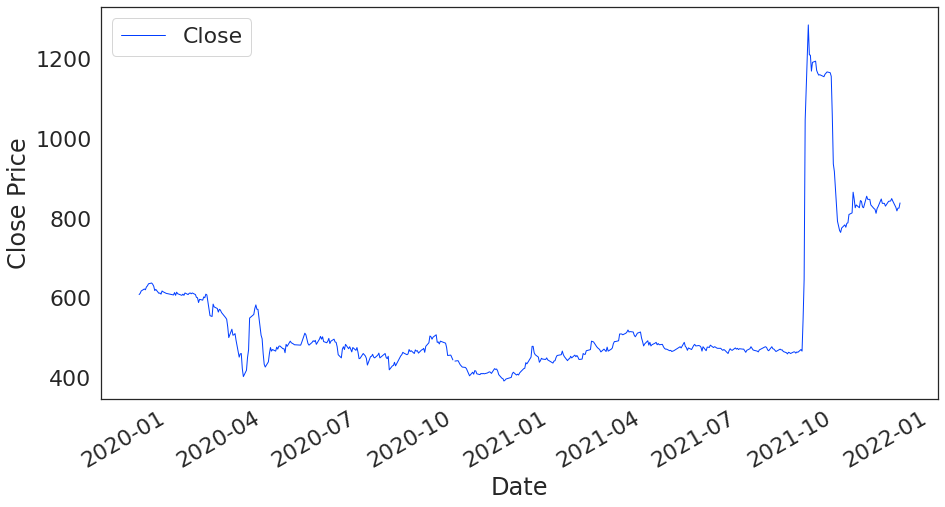

In [108]:
close9663 = values9663.copy()
close9663 = close9663.iloc[:, [1,6]]

time = (close9663['Date'] > '2019-12-03') & (close9663['Date'] <= '2021-12-03')
close9663 = close9663.loc[time]

# Plot the timeseries 
pd.plotting.register_matplotlib_converters()
ax = close9663.set_index('Date').plot(figsize=(15, 8), linewidth=1)
ax.set_ylabel('Close Price')
ax.set_xlabel('Date')
#ax.set_xticks(range(488))

plt.show()

### Plot Target

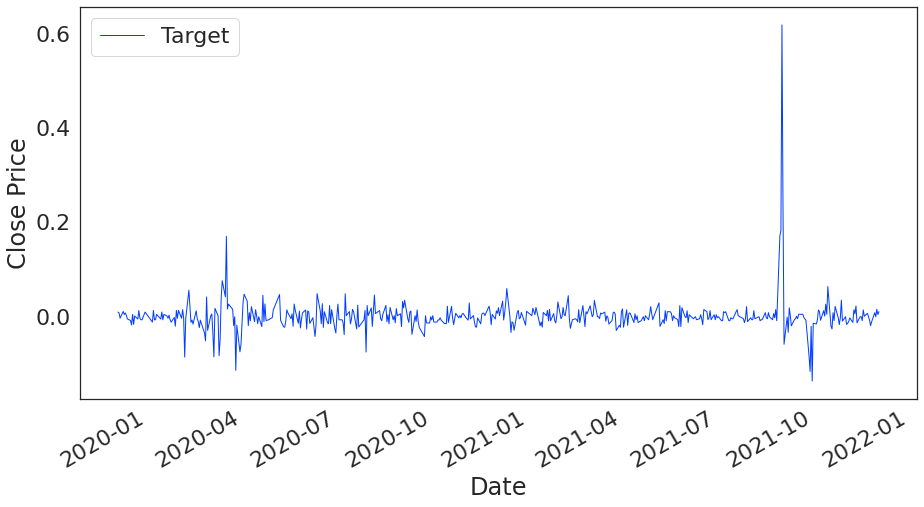

In [109]:
close9663 = values9663.copy()
close9663 = close9663.iloc[:, [1,11]]

time = (close9663['Date'] > '2019-12-03') & (close9663['Date'] <= '2021-12-03')
close9663 = close9663.loc[time]

# Plot the timeseries 
pd.plotting.register_matplotlib_converters()
ax = close9663.set_index('Date').plot(figsize=(15, 8), linewidth=1)
ax.set_ylabel('Close Price')
ax.set_xlabel('Date')
#ax.set_xticks(range(488))

plt.show()

### Zoom in on Target and Close

#### Close

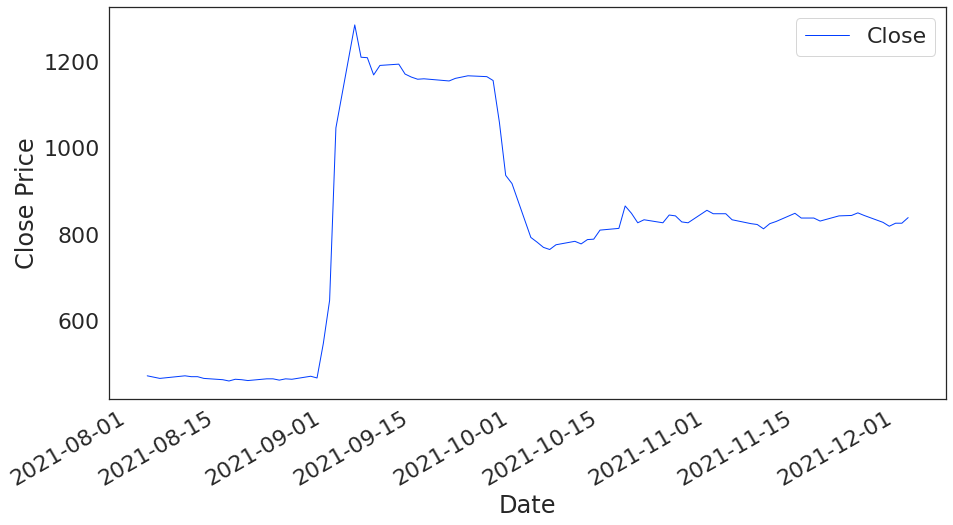

In [110]:
close9663 = values9663.copy()
close9663 = close9663.iloc[:, [1,6]]

time = (close9663['Date'] > '2021-08-03') & (close9663['Date'] <= '2021-12-03')
close9663 = close9663.loc[time]

# Plot the timeseries 
pd.plotting.register_matplotlib_converters()
ax = close9663.set_index('Date').plot(figsize=(15, 8), linewidth=1)
ax.set_ylabel('Close Price')
ax.set_xlabel('Date')
#ax.set_xticks(range(488))

plt.show()

#### Target

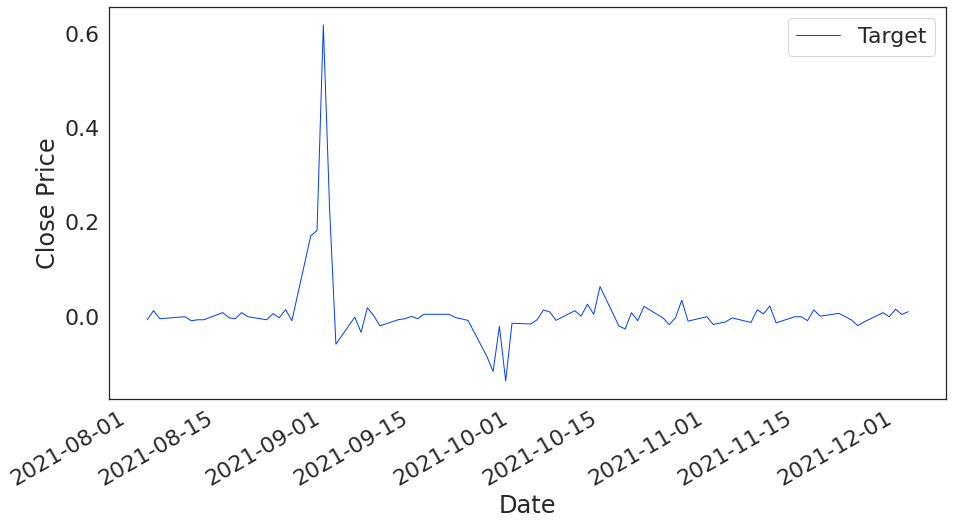

In [111]:
close9663 = values9663.copy()
close9663 = close9663.iloc[:, [1,11]]

time = (close9663['Date'] > '2021-08-03') & (close9663['Date'] <= '2021-12-03')
close9663 = close9663.loc[time]

# Plot the timeseries 
pd.plotting.register_matplotlib_converters()
ax = close9663.set_index('Date').plot(figsize=(15, 8), linewidth=1)
ax.set_ylabel('Close Price')
ax.set_xlabel('Date')
#ax.set_xticks(range(488))

plt.show()

### Summary:
* The target - Sharpe Ratio - changes in the correct direction before the close price change, which signifies that the target is able to predict stock price changes.

## Stationarity Test

In [114]:
# create new df with datetime index and Target row only
#df_ind = df.set_index(['A', 'B'])
values1301_copy = values9663.copy()
values1301_copy = values1301_copy.iloc[:, [1,11]]
values1301_copy = values1301_copy.set_index(['Date'])
values1301_copy

,Target
Date,
2017-01-04,-0.024213
2017-01-05,-0.002481
2017-01-06,-0.017413
2017-01-10,0.007595
2017-01-11,0.010050
...,...
2021-11-29,0.008547
2021-11-30,0.000000
2021-12-01,0.015738


### Stationarity Test Function

In [115]:
from statsmodels.tsa.stattools import adfuller
import numpy as np
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

### Test Stationarity

In [116]:
check_stationarity(values1301_copy)

The series is stationary


### Test Stationarity of stocks used for testing

In [118]:
for stock in rand_stocks:
    # Pull one stock's values for given stock from stock_prices
    values9663 = df1.loc[df1['SecuritiesCode'] == stock]                   
    values9663['Date'] = pd.to_datetime(values9663['Date'], format = '%Y-%m-%d')
    
    # create new df with datetime index and Target row only
    #df_ind = df.set_index(['A', 'B'])
    values1301_copy = values9663.copy()
    values1301_copy = values1301_copy.iloc[:, [1,11]]
    values1301_copy = values1301_copy.set_index(['Date'])
    
    print('Stock number '+str(stock)+': ')
    check_stationarity(values1301_copy)

Stock number 7596: 
The series is stationary
Stock number 4998: 
The series is stationary
Stock number 5802: 
The series is stationary
Stock number 9663: 
The series is stationary
Stock number 4464: 
The series is stationary


## Correlation Heat Map

In [294]:
heat_map = stock_list_df.copy()
#eat_map.info()

In [285]:
feat_heat_range = [*range(9, 20, 1), 8]
feat_heat_range

[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 8]

In [295]:
# Create heat map df for prices and financial/stock_list information
prices_heat_map = heat_map.iloc[:, 0:9]
fin_heat_map = heat_map.iloc[:, feat_heat_range]

# Create range and df for engineered features
feat_heat_range = [*range(19, 30, 1), 8]
feat_heat_map = heat_map.iloc[:, feat_heat_range]
#feat_heat_map

### Prices Heat Map

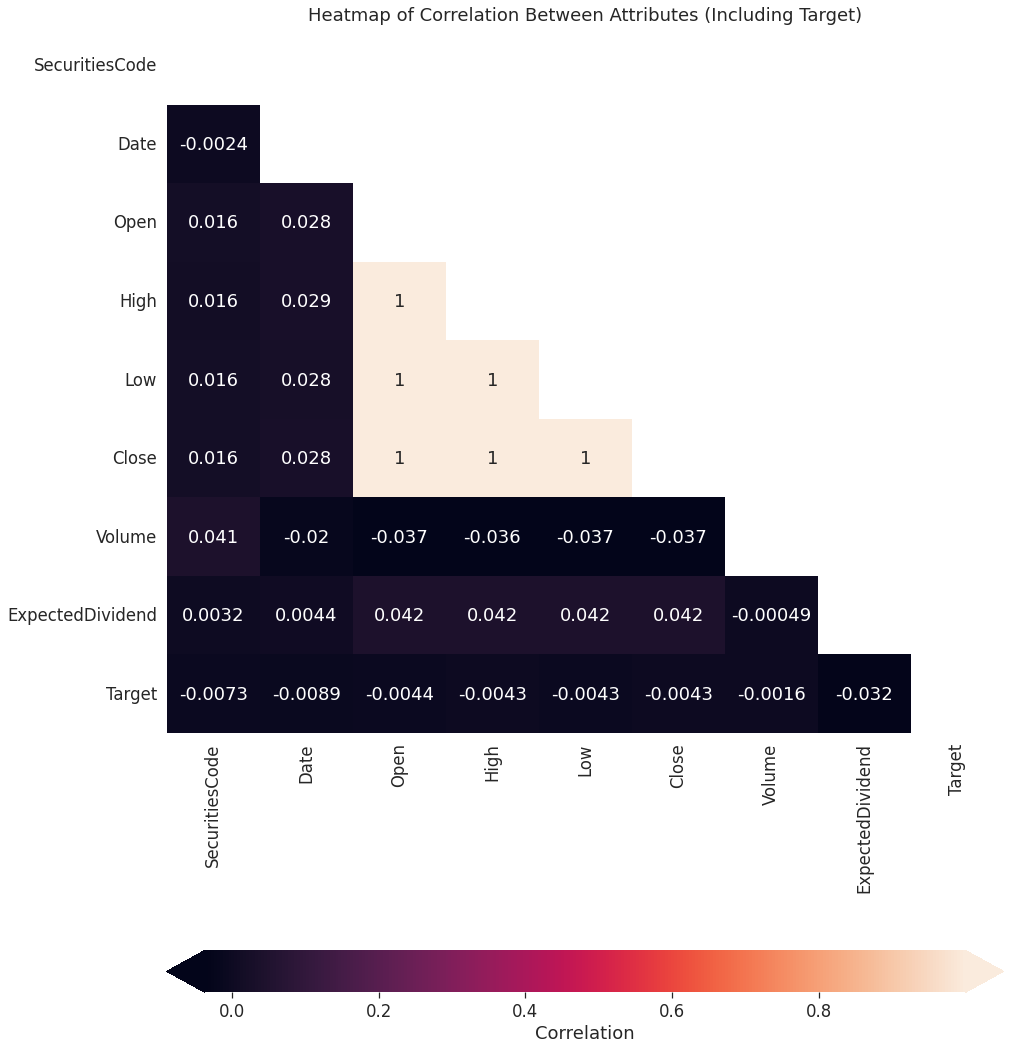

In [291]:
heat_map = prices_heat_map.copy()
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = heat_map
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Financials and Stock List Heat Map

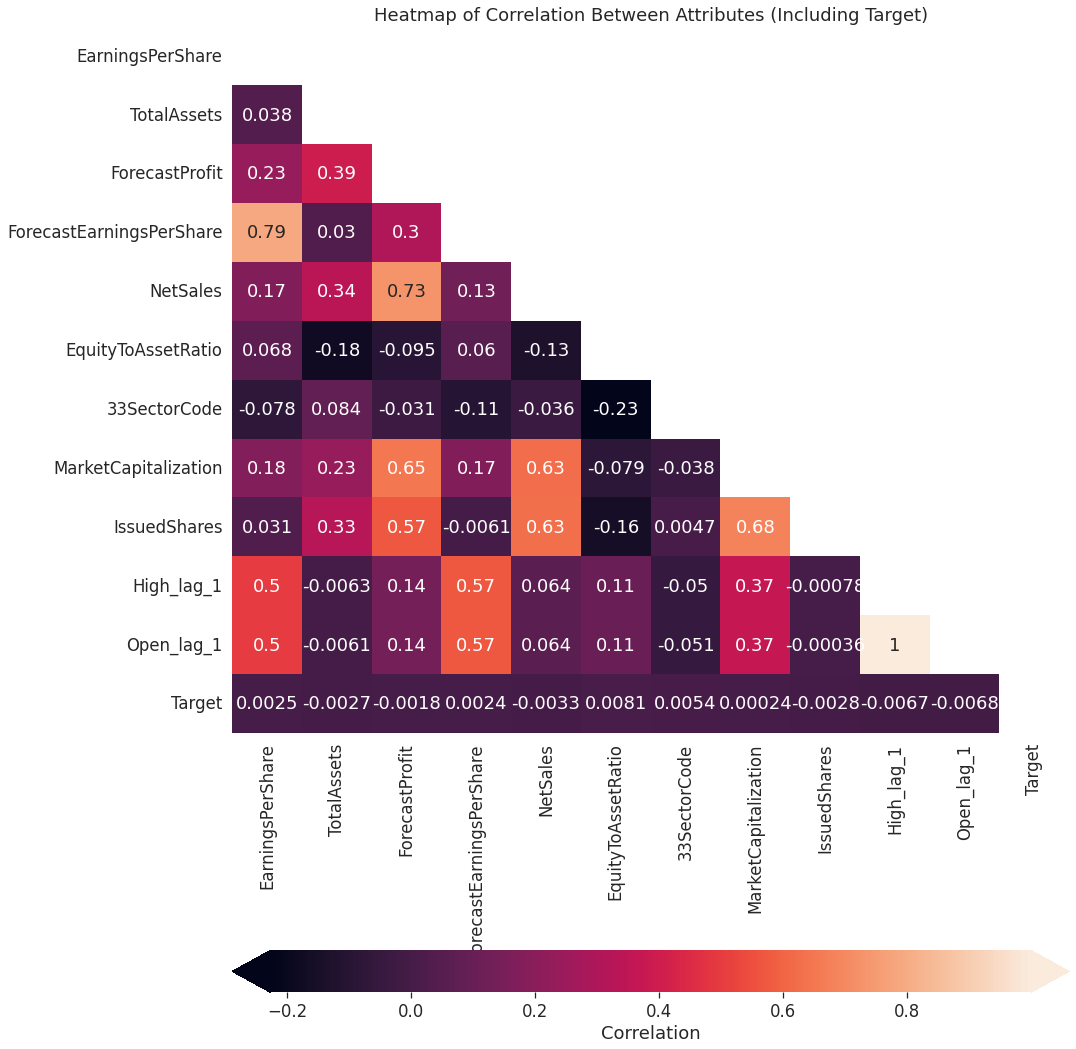

In [290]:
heat_map = fin_heat_map.copy()
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = heat_map
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Engineered Features Heat Map

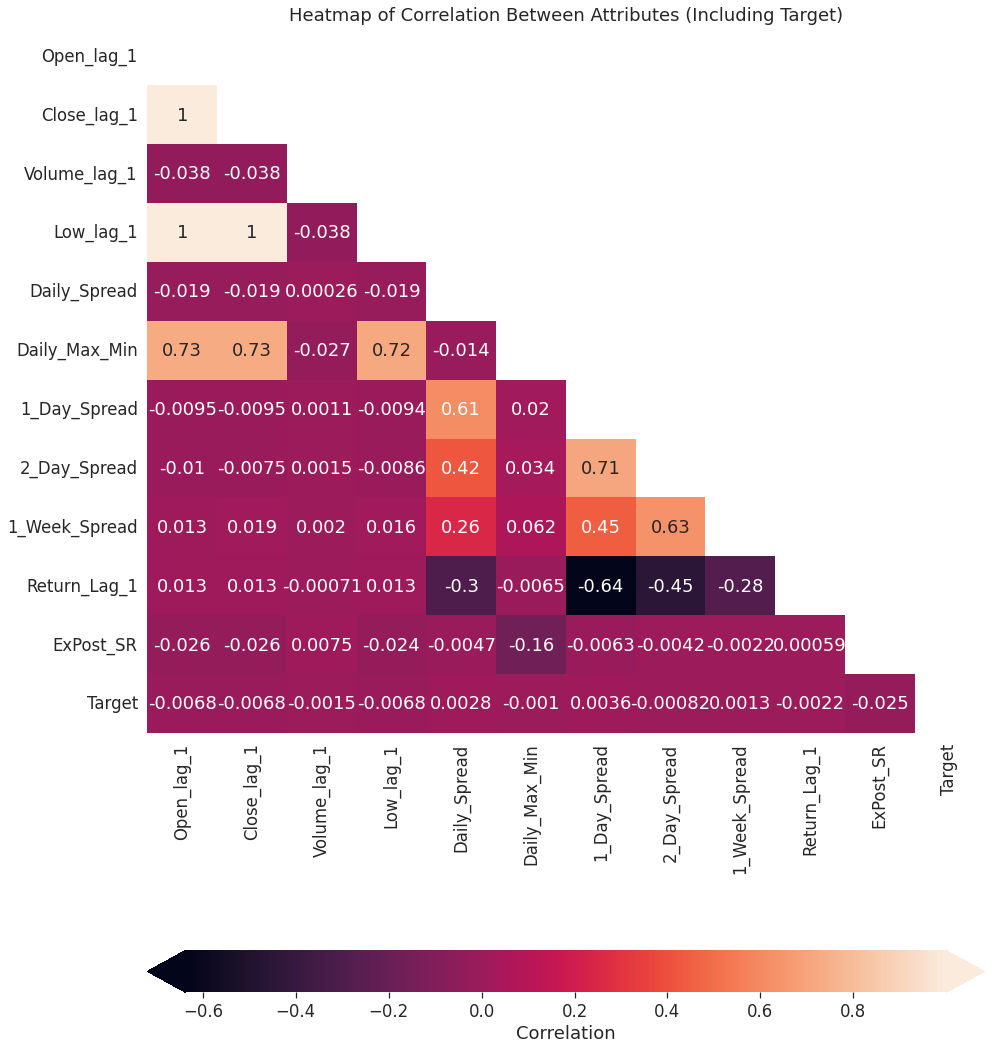

In [296]:
heat_map = feat_heat_map.copy()
# Create a df with the target as the first column,
# then compute the correlation matrix
heatmap_data = heat_map
corr = heatmap_data.corr()

# Set up figure and axes
fig, ax = plt.subplots(figsize=(15, 20))

# Plot a heatmap of the correlation matrix, with both
# numbers and colors indicating the correlations
sns.heatmap(
    # Specifies the data to be plotted
    data=corr,
    # The mask means we only show half the values,
    # instead of showing duplicates. It's optional.
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    # Specifies that we should use the existing axes
    ax=ax,
    # Specifies that we want labels, not just colors
    annot=True,
    # Customizes colorbar appearance
    cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
)

# Customize the plot appearance
ax.set_title("Heatmap of Correlation Between Attributes (Including Target)");

### Summary
* The ExPost_SR Feature, which calculates an improvised Sharpe Ratio based on the current day's close is the most correlated to the target.
* Date is the second-most correlated.
* Equity to Asset Ratio is the third-most correlated.
* None of these features correlate closely with the Target

# Compare Models
* Use 5 randomly picked stocks
* Keep same 5 stocks for every model and compare results for individual stocks

In [18]:
# Code commented-out as stocks selected in previous notebook runs

# Create list of all securities codes
#all_stocks_list = df1['SecuritiesCode'].values.tolist()

# Select 5 random stocks
#rand_stocks = random.choices(all_stocks_list, k=5)

In [19]:
# Random Stocks List
rand_stocks = [7596, 4998, 5802, 9663, 4464]
rand_stocks

[7596, 4998, 5802, 9663, 4464]

## ARIMA Model

In [143]:
ARIMA_df = df1.copy()

# Set Datetime index
ARIMA_df['Date'] = pd.to_datetime(ARIMA_df['Date'], format='%Y/%m/%d', errors='coerce')
mask = ARIMA_df['Date'].isnull()
ARIMA_df.loc[mask, 'Date'] = pd.to_datetime(ARIMA_df['Date'], format='%Y/%m/%d',
                                            errors='coerce')
ARIMA_df = ARIMA_df.set_index(['Date'])
ARIMA_df

,RowId,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
Date,,,,,,,,,,,
2017-01-04,20170104_1301,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
2017-01-04,20170104_1332,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2017-01-04,20170104_1333,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
2017-01-04,20170104_1376,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
2017-01-04,20170104_1377,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-03,20211203_9990,9990,514.0,528.0,513.0,528.0,44200,1.0,NaN,False,0.034816
2021-12-03,20211203_9991,9991,782.0,794.0,782.0,794.0,35900,1.0,NaN,False,0.025478
2021-12-03,20211203_9993,9993,1690.0,1690.0,1645.0,1645.0,7200,1.0,NaN,False,-0.004302


In [144]:
# Min_max scale target
df2 = ARIMA_df['Target']
df2 = pd.DataFrame(df2)
df2 = min_max(df2)

# Add securities codes back into df for id
df2['SecuritiesCode'] = ARIMA_df['SecuritiesCode']

In [145]:
# Use df2 and reset index to bring date in as column in df
df3 = df2.reset_index(drop=False)

# Pivot table to include only Target based on SecuritiesCode
df3 = df3.pivot(index='Date', columns='SecuritiesCode', values='Target')

In [313]:
#df3

### Model and Plot

Test RMSE: 0.016


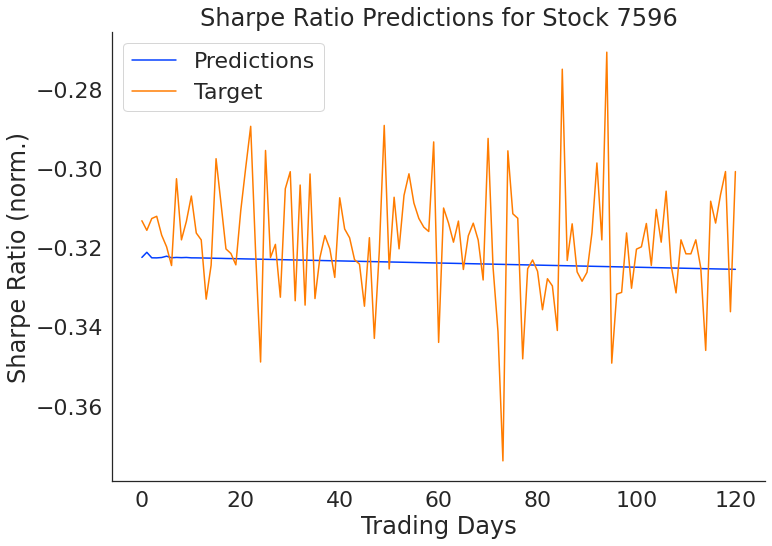

Test RMSE: 0.013


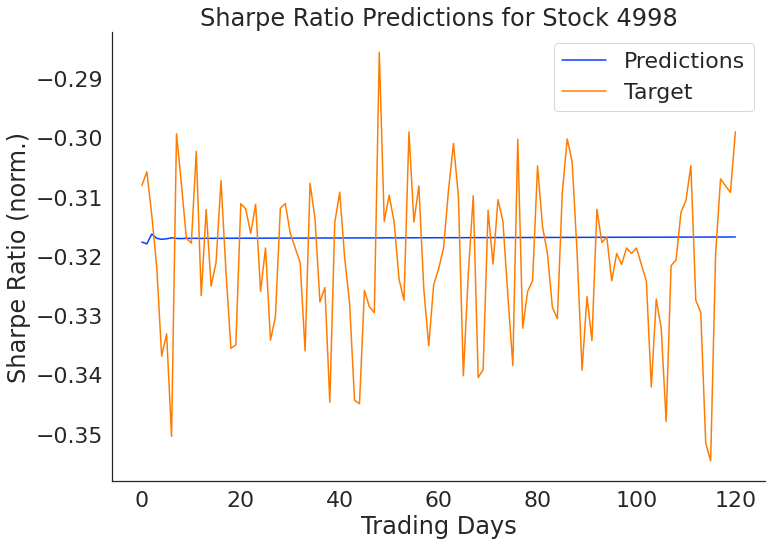

Test RMSE: 0.026


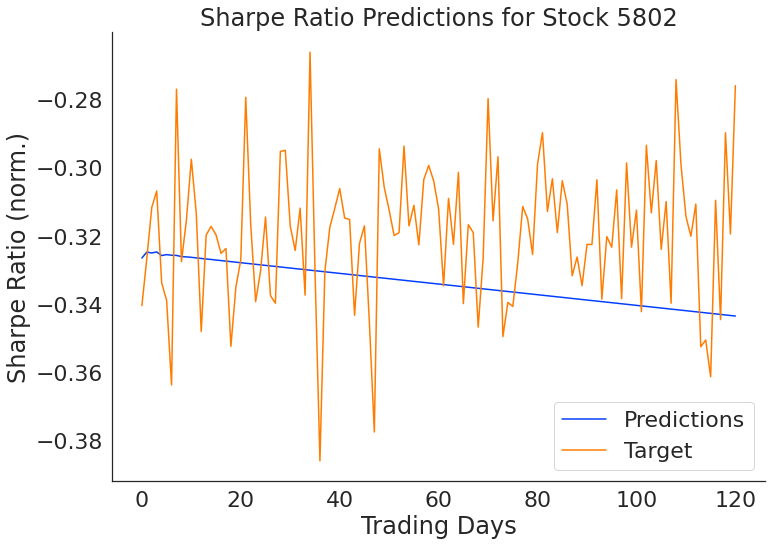

Test RMSE: 0.028


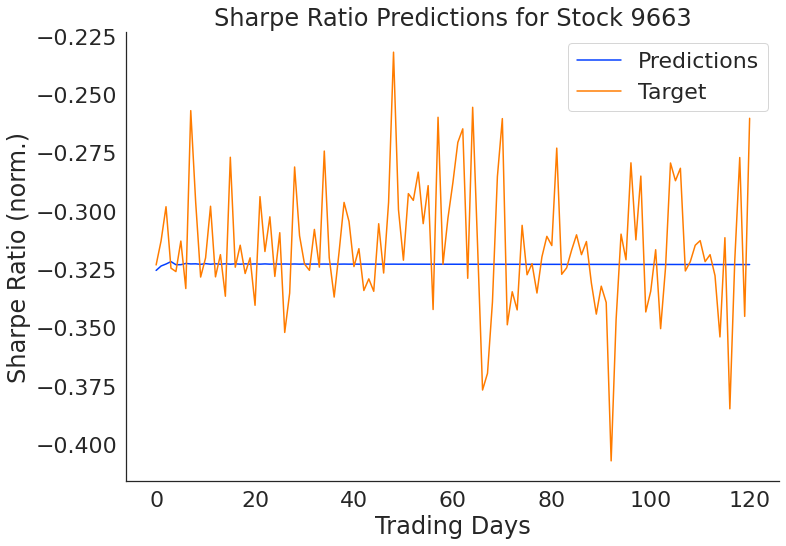

Test RMSE: 0.019


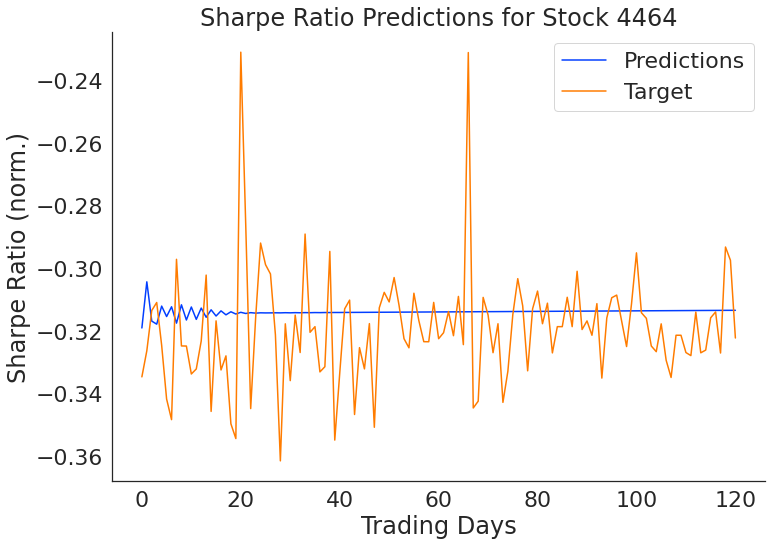

In [146]:
# Create df with rand_stock list
rand_df = df3[rand_stocks]

# Create RMSE List
RMSE_ARIMA = {}

preds_df = pd.DataFrame()

for code in rand_stocks:
    df = rand_df[code]
    df = pd.DataFrame(df)
    
    # split into train and test sets
    X = rand_df[code].values
    size = int(len(X) * 0.9)
    train, test = X[0:size], X[size:len(X)]
    
    # Model stock 
    model = ARIMA(train, order=(4,2,2))
    model.initialize_approximate_diffuse()
    model_fit = model.fit()
    output = model_fit.forecast(steps=121)
    pred = pd.DataFrame(output)

    # evaluate forecasts
    rmse = sqrt(mean_squared_error(test, output))
    
    # Store and print RMSE
    RMSE_ARIMA[code] = [rmse]
    print('Test RMSE: %.3f' % rmse)
    
    # df with Predictions and Target
    date_df = pd.DataFrame()
    date_df['Predictions'] = pred
    date_df['Target'] = test

    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=date_df, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions for Stock '+str(code), 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )
    sns.despine()

    plt.show()

## LSTM Model

### Define Model

In [208]:
def get_model(params, input_shape):
    model = Sequential()
    model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=True))
    model.add(Dropout(rate=params["dropout"]))

    model.add(LSTM(units=params["lstm_units"], return_sequences=False))
    model.add(Dropout(rate=params["dropout"]))

    model.add(Dense(1))

    model.compile(loss=params["loss"],
              	optimizer=params["optimizer"],
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

    return model

### Create Training Data Frame

In [209]:
# Create df with rand_stock list
rand_df = stock_list_df.loc[stock_list_df['SecuritiesCode'].isin(rand_stocks)]

# Copy of rand_df to ensure it stays the same with all three models
mult_stocks = rand_df.copy()
#mult_stocks.info()

### Model and Plot

Test RMSE: 0.018


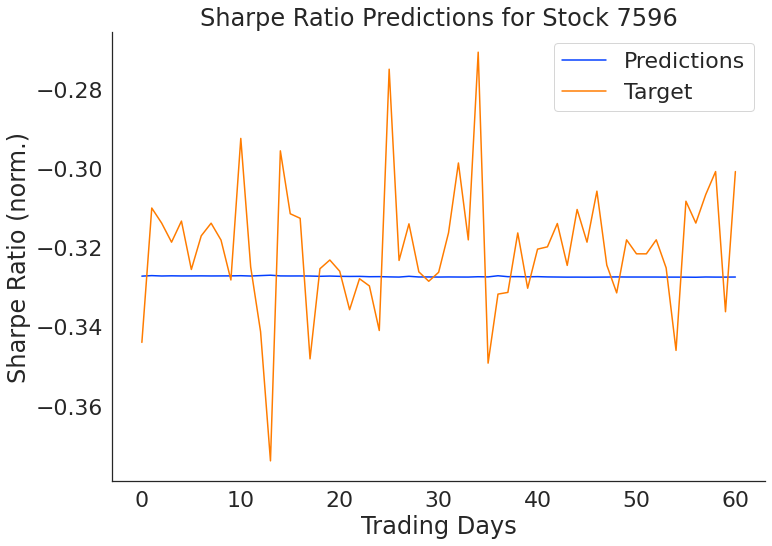

Test RMSE: 0.014


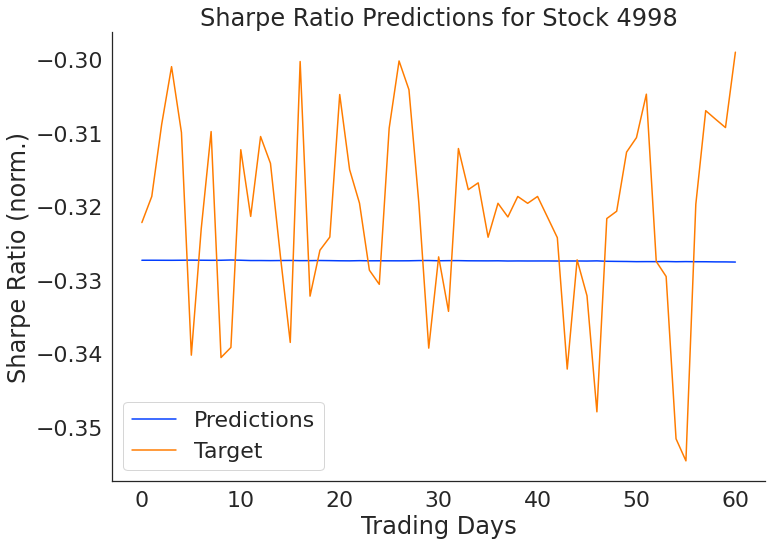

Test RMSE: 0.020


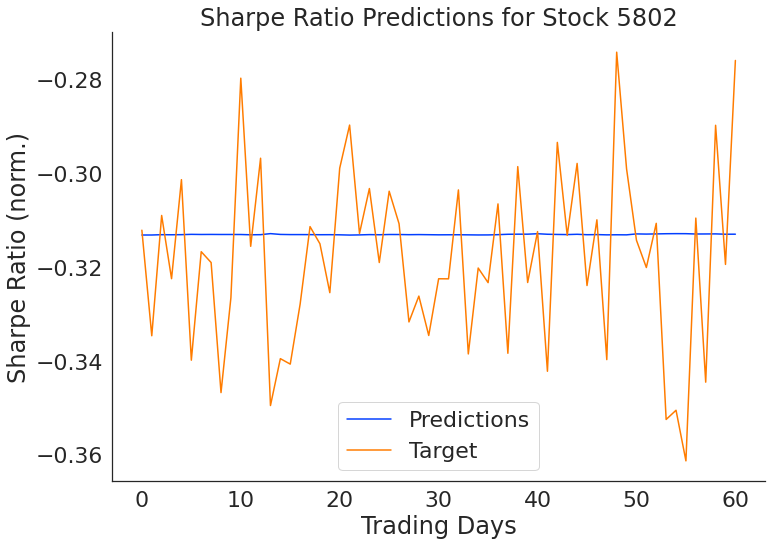

Test RMSE: 0.031


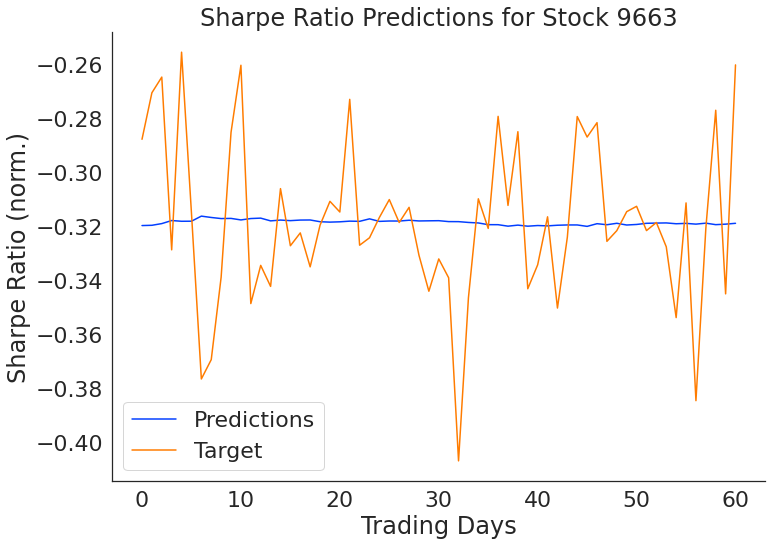

Test RMSE: 0.015


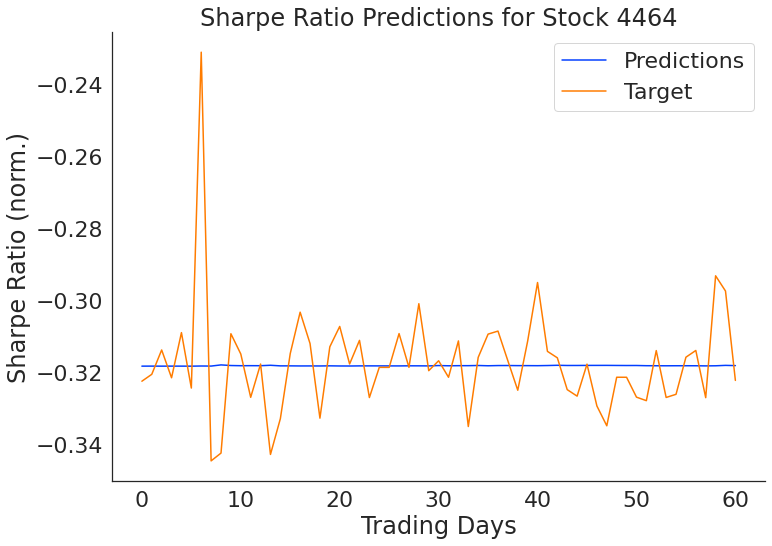

In [212]:
# Create RMSE List
RMSE_LSTM = {}

preds_df = pd.DataFrame()

for code in rand_stocks:
    # Split df into train/test
    values = mult_stocks.loc[mult_stocks['SecuritiesCode'] == code]
    
    n = len(values)
    train_df = values[0:int(n*0.95)]
    test_df = values[int(n*0.95):]
    
    x_train = train_df.drop('Target', axis=1)
    y_train = train_df['Target']

    x_test = test_df.drop('Target', axis=1)
    y_test = test_df['Target']

    x_train, y_train = np.expand_dims(np.array(x_train), 2), np.expand_dims(np.expand_dims(np.array(y_train),1), 1)
    x_test, y_test = np.expand_dims(np.array(x_test), 2), np.expand_dims(np.expand_dims(np.array(y_test),1), 1)
    
    params = {
    "loss": "mean_squared_error",
    "optimizer": "adam",
    "dropout": 0.2,
    "lstm_units": 90,
    "epochs": 5,
    "batch_size": 128,
    "es_patience" : 10
    }

    model = get_model(params=params, input_shape=x_train.shape[1])
    
    history = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=0,
    )
    
    # Generate Predictions
    preds = model.predict(x_test)

    # Remove second dimension
    preds = np.squeeze(preds, axis=(1,))

    # Make array of test values
    y_val = test_df['Target'].values
    
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(y_val, preds))
    
        # Store and print RMSE
    RMSE_LSTM[code] = [rmse]
    print('Test RMSE: %.3f' % rmse)

    plot_LSTM(preds, y_val)

## Random Forest Models

### Single RFR Model

In [300]:
# Merge Stock List with mult_stocks_merge
mult_stock_list = stock_list_df.loc[stock_list_df['SecuritiesCode'].isin(rand_stocks)]

mult_stock_list

,SecuritiesCode,Date,Open,High,Low,Close,Volume,ExpectedDividend,Target,EarningsPerShare,...,Close_lag_1,Volume_lag_1,Low_lag_1,Daily_Spread,Daily_Max_Min,1_Day_Spread,2_Day_Spread,1_Week_Spread,Return_Lag_1,ExPost_SR
1052443,5802,-1.0,-0.969537,-0.968901,-0.968756,-0.968677,-0.989539,-1.0,-0.355908,-0.285236,...,-1.000000,-1.000000,-1.000000,0.075939,-0.993974,0.050139,0.062072,0.060244,-0.809431,-0.356917
945939,4998,-1.0,-0.987029,-0.987111,-0.986827,-0.987054,-0.999873,-1.0,-0.299142,-0.307059,...,-1.000000,-1.000000,-1.000000,0.072490,-0.998940,0.050139,0.062072,0.060244,-0.809431,-0.612557
750652,4464,-1.0,-0.985592,-0.985681,-0.985278,-0.985594,-0.999987,-1.0,-0.314221,-0.295306,...,-1.000000,-1.000000,-1.000000,0.072567,-0.999470,0.050139,0.062072,0.060244,-0.809431,-0.303544
2226971,9663,-1.0,-0.917297,-0.916912,-0.916464,-0.916813,-0.999985,-1.0,-0.319893,-0.268687,...,-1.000000,-1.000000,-1.000000,0.073563,-0.984768,0.050139,0.062072,0.060244,-0.809431,-0.525737
1631815,7596,-1.0,-0.977278,-0.977083,-0.976751,-0.977103,-0.999962,-1.0,-0.308381,-0.301130,...,-1.000000,-1.000000,-1.000000,0.073180,-0.997086,0.050139,0.062072,0.060244,-0.809431,-0.013325
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053644,5802,1.0,-0.973139,-0.973028,-0.972861,-0.972794,-0.993696,-1.0,-0.275874,-0.302269,...,-0.972035,-0.982790,-0.971727,0.073831,-0.995033,0.051046,0.062147,0.058140,-0.814219,-0.379114
751853,4464,1.0,-0.977496,-0.976956,-0.976900,-0.976939,-0.999969,-1.0,-0.322207,-0.295900,...,-0.976646,-0.999970,-0.976569,0.074789,-0.995099,0.050819,0.062520,0.060692,-0.813660,-0.312787
947140,4998,1.0,-0.979806,-0.979563,-0.979270,-0.979587,-0.999915,-1.0,-0.298970,-0.291716,...,-0.979078,-0.999856,-0.978855,0.073410,-0.997351,0.050391,0.062595,0.059049,-0.811198,-0.613336
2228172,9663,1.0,-0.804504,-0.796624,-0.799472,-0.796852,-0.999932,-1.0,-0.260179,-0.284776,...,-0.793619,-0.999474,-0.791813,0.101916,-0.935099,0.059713,0.071029,0.046303,-0.816255,-0.544074


In [311]:
mult_stock_list.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6012 entries, 1052443 to 1633018
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SecuritiesCode            6012 non-null   int64  
 1   Date                      6012 non-null   float64
 2   Open                      6012 non-null   float64
 3   High                      6012 non-null   float64
 4   Low                       6012 non-null   float64
 5   Close                     6012 non-null   float64
 6   Volume                    6012 non-null   float64
 7   ExpectedDividend          6012 non-null   float64
 8   Target                    6012 non-null   float64
 9   EarningsPerShare          6012 non-null   float64
 10  TotalAssets               6012 non-null   float64
 11  ForecastProfit            6012 non-null   float64
 12  ForecastEarningsPerShare  6012 non-null   float64
 13  NetSales                  6012 non-null   float64
 14 

#### Split into Train/Test

In [301]:
# Split df into train/test
column_indices = {name: i for i, name in enumerate(mult_stock_list.columns)}

n = len(mult_stock_list)
train_df = mult_stock_list[0:int(n*0.9)]
test_df = mult_stock_list[int(n*0.9):]

# create Train X and y df's
X_train = train_df.drop('Target', axis=1)
y_train = train_df['Target']

# create Test X and y df's
X_test = test_df.drop('Target', axis=1)
y_test = test_df['Target']

print('Training Shape:', train_df.shape)
print('Test Shape:', test_df.shape)

Training Shape: (5410, 30)
Test Shape: (602, 30)


#### Fit Model

In [302]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(random_state = 42)

# Train the model on training data
rf.fit(X_train, y_train);

#### Predictions and Mean Absolute Error

In [303]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)

# Calculate the absolute errors
errors = abs(predictions - y_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'of the Sharpe Ratio')

Mean Absolute Error: 0.01 of the Sharpe Ratio


#### Plot Predictions vs Actual

Test RMSE: 0.019


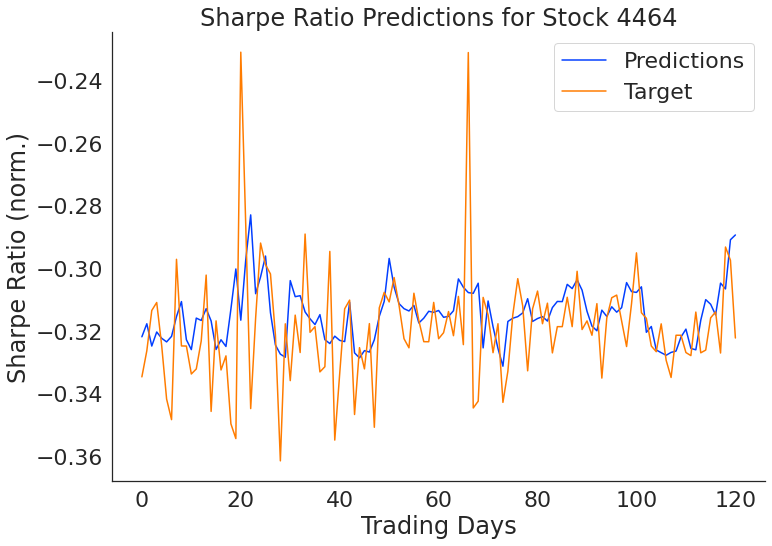

Test RMSE: 0.013


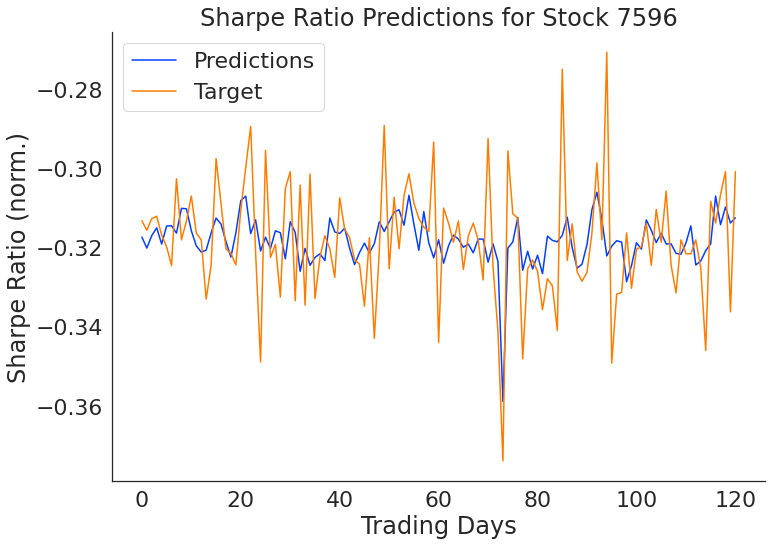

Test RMSE: 0.011


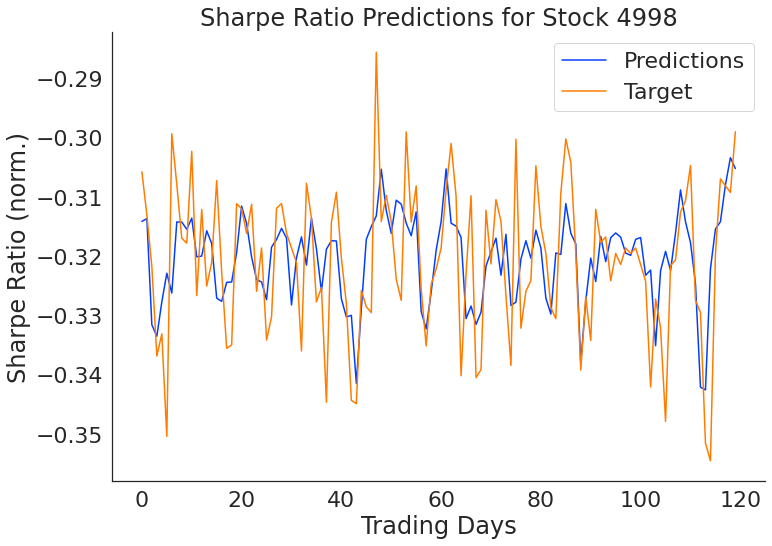

Test RMSE: 0.028


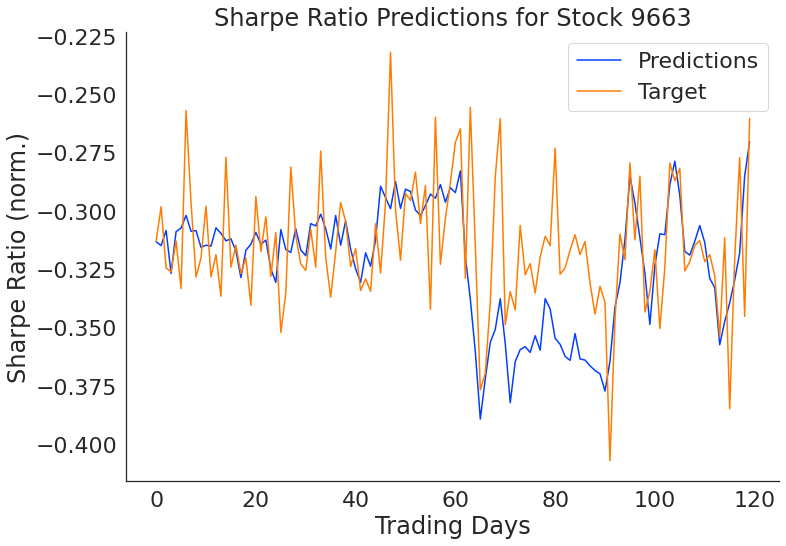

Test RMSE: 0.017


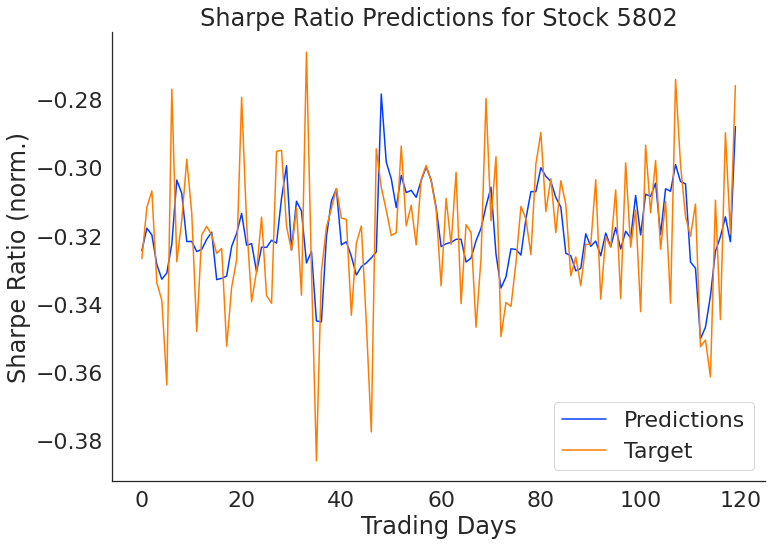

In [305]:
# Create RMSE List
RMSE_stocklist = {}

# Create df with date, preds, and target
date_df = X_test.Date
date_df = pd.DataFrame(date_df)
date_df['Predictions'] = predictions
date_df['Target'] = y_test

# Add Securities Codes to df
sec_code_df = X_test['SecuritiesCode']
sec_code_df = pd.DataFrame(sec_code_df)
preds_df = pd.concat([date_df, sec_code_df], axis=1)

# Create list of Securities Codes
sec_list = preds_df.SecuritiesCode.unique().tolist()

# Plot predictions for each stock
for code in sec_list:
    dfg = preds_df.loc[preds_df['SecuritiesCode'] == code]
    dfg = dfg.reset_index(drop=True)
    dfg = dfg.drop('SecuritiesCode', axis=1)
    dfg = dfg.drop('Date', axis=1)
    
    # evaluate forecasts
    rmse = sqrt(mean_squared_error(dfg['Target'].values, dfg['Predictions'].values))
    RMSE_stocklist[code] = [rmse]
    print('Test RMSE: %.3f' % rmse)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=dfg, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions for Stock '+str(code), 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )
    sns.despine()

    x = plt.show()

#### Feature Importance

In [306]:
# Saving feature names
feature_list = list(X_test.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: ExPost_SR            Importance: 0.26
Variable: 2_Day_Spread         Importance: 0.07
Variable: Return_Lag_1         Importance: 0.07
Variable: Volume               Importance: 0.06
Variable: Volume_lag_1         Importance: 0.06
Variable: Daily_Spread         Importance: 0.06
Variable: 1_Week_Spread        Importance: 0.06
Variable: Daily_Max_Min        Importance: 0.05
Variable: 1_Day_Spread         Importance: 0.05
Variable: Date                 Importance: 0.03
Variable: Open                 Importance: 0.02
Variable: High                 Importance: 0.02
Variable: Close                Importance: 0.02
Variable: EquityToAssetRatio   Importance: 0.02
Variable: Open_lag_1           Importance: 0.02
Variable: Low_lag_1            Importance: 0.02
Variable: Low                  Importance: 0.01
Variable: ExpectedDividend     Importance: 0.01
Variable: EarningsPerShare     Importance: 0.01
Variable: TotalAssets          Importance: 0.01
Variable: ForecastProfit       Importanc

### Individual RFR Models

#### Model and Plot

In [308]:
target_df

,Date,7596,Target
0,0.971094,-0.314742,-0.313166
1,0.971143,-0.320254,-0.315587
2,0.971192,-0.318414,-0.312607
3,0.971338,-0.315893,-0.312043
4,0.971386,-0.316237,-0.316809
...,...,...,...
116,0.996399,-0.302113,-0.313756
117,0.996448,-0.312537,-0.306564
118,0.999903,-0.309049,-0.300737
119,0.999951,-0.310353,-0.336162


Test RMSE: 0.013


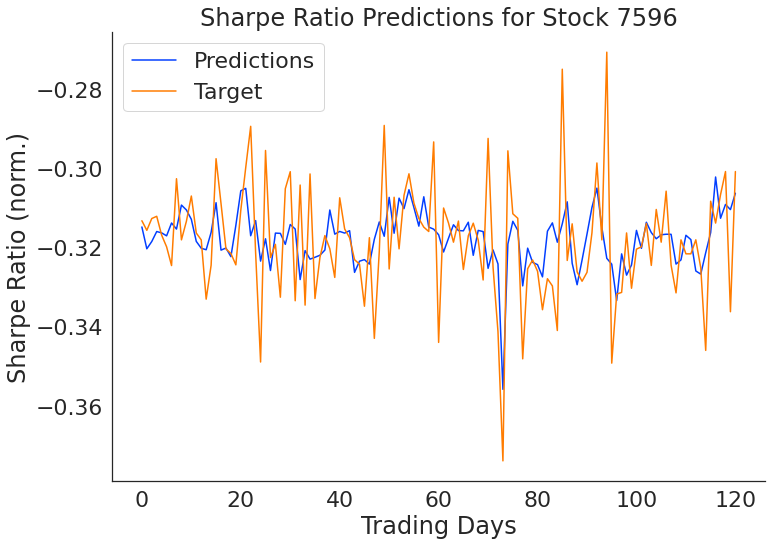

Test RMSE: 0.011


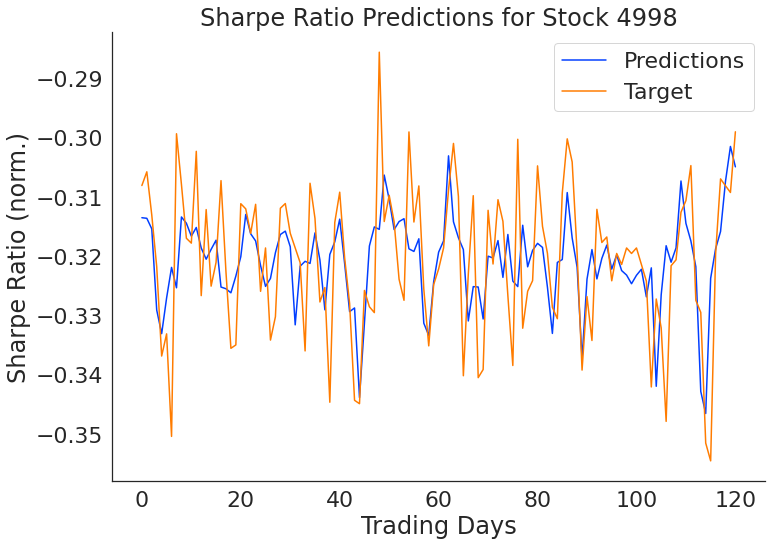

Test RMSE: 0.017


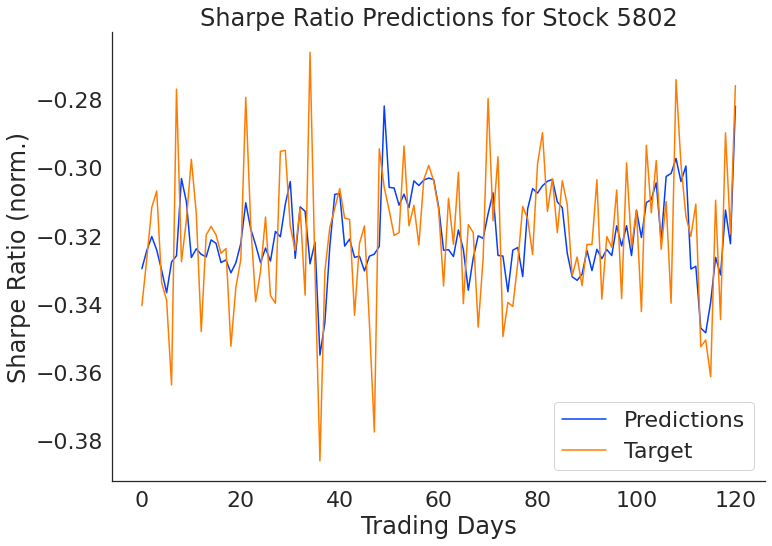

Test RMSE: 0.023


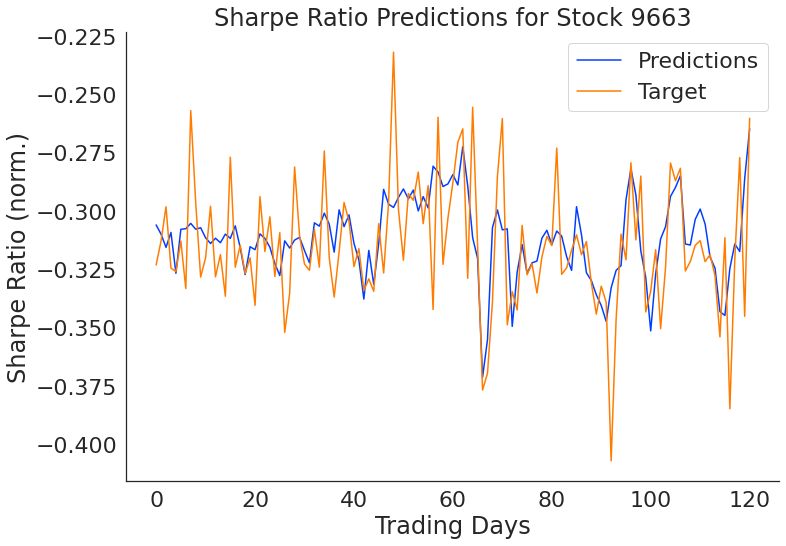

Test RMSE: 0.021


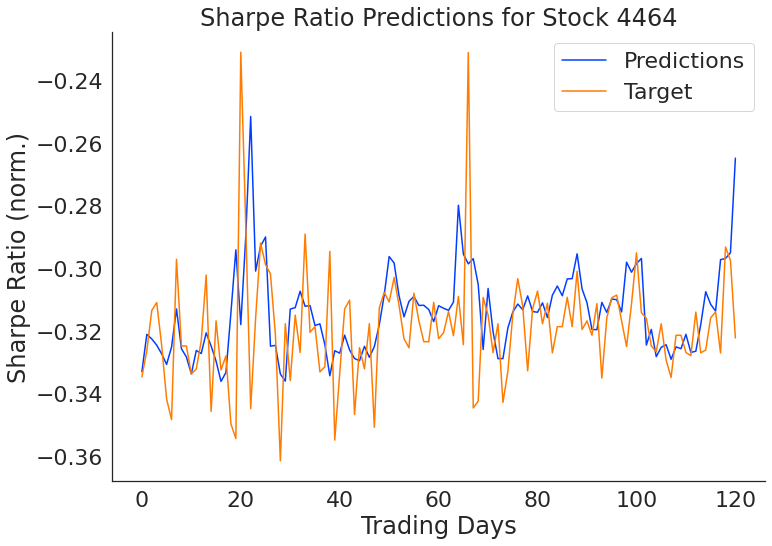

In [310]:
# Create RMSE List
RMSE_mult_stocks = {}

# Create Preds df
preds_df = pd.DataFrame()

# Run Model and Plot for all 5 stocks
for code in rand_stocks:
    dfg = mult_stock_list.loc[mult_stock_list['SecuritiesCode'] == code]
    
    # Train, Test, Split
    n = len(dfg)
    train_df = dfg[0:int(n*0.9)]
    test_df = dfg[int(n*0.9):]
    
        # create Train X and y df's
    X_train = train_df.drop('Target', axis=1)
    y_train = train_df['Target']

        # create Test X and y df's
    X_test = test_df.drop('Target', axis=1)
    y_test = test_df['Target']
    
    # Instantiate and Fit Model
    rf = RandomForestRegressor(random_state = 42)

    # Train the model on training data
    rf.fit(X_train, y_train);
    
    # df of preds by sec code
    predictions = rf.predict(X_test)
    predies_df = pd.DataFrame(data=predictions, columns=[code])
    
    # date and preds in same df
    date_df = X_test.Date
    date_df = pd.DataFrame(date_df)
    date_df = date_df.reset_index(drop=True)
    plot_df = pd.concat([date_df, predies_df], axis=1)

    target_df = pd.DataFrame(data=y_test)
    target_df = target_df.reset_index(drop=True)
    target_df = pd.concat([plot_df, target_df], axis=1)
    
    # evaluate forecasts with RMSE
    rmse = sqrt(mean_squared_error(y_test, predictions))
    
    # Store and print RMSE
    RMSE_mult_stocks[code] = [rmse]
    print('Test RMSE: %.3f' % rmse)
    
    # Drop Date column
    target_df = target_df.rename(columns={code: "Predictions"})
    target_df = target_df.drop(['Date'], axis=1)
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})

    sns.set_theme(style="white", palette='bright', font_scale=2)

    ax = sns.lineplot(data=target_df, 
                          palette="bright", 
                          markers=False, 
                          dashes=False).set(title='Sharpe Ratio Predictions for Stock '+str(code), 
                                            xlabel="Trading Days",
                                            ylabel= "Sharpe Ratio (norm.)"
                                            )
    sns.despine()

    x = plt.show()

## RMSE Plot

In [194]:
RMSE_mult_df = pd.DataFrame(RMSE_mult_stocks)
RMSE_stocklist_df = pd.DataFrame(RMSE_stocklist)
RMSE_LSTM_df = pd.DataFrame(RMSE_LSTM)
RMSE_ARIMA_df = pd.DataFrame(RMSE_ARIMA)

In [195]:
RMSE_mult_df = pd.DataFrame(RMSE_mult_df.unstack())
RMSE_mult_df = RMSE_mult_df.rename(columns={0: "RMSE"})
RMSE_mult_df = RMSE_mult_df.droplevel(level=1)
RMSE_mult_df['Model_Type'] = 'Individual_Random_Forests'
RMSE_mult_df = RMSE_mult_df.reset_index(drop=False)
RMSE_mult_df = RMSE_mult_df.rename(columns={"index": "Securities_Code"})

In [196]:
RMSE_stocklist_df = pd.DataFrame(RMSE_stocklist_df.unstack())
RMSE_stocklist_df = RMSE_stocklist_df.rename(columns={0: "RMSE"})
RMSE_stocklist_df = RMSE_stocklist_df.droplevel(level=1)
RMSE_stocklist_df['Model_Type'] = 'Single_Random_Forest'
RMSE_stocklist_df = RMSE_stocklist_df.reset_index(drop=False)
RMSE_stocklist_df = RMSE_stocklist_df.rename(columns={"index": "Securities_Code"})

In [197]:
RMSE_LSTM_df = pd.DataFrame(RMSE_LSTM_df.unstack())
RMSE_LSTM_df = RMSE_LSTM_df.rename(columns={0: "RMSE"})
RMSE_LSTM_df = RMSE_LSTM_df.droplevel(level=1)
RMSE_LSTM_df['Model_Type'] = 'LSTM_Model'
RMSE_LSTM_df = RMSE_LSTM_df.reset_index(drop=False)
RMSE_LSTM_df = RMSE_LSTM_df.rename(columns={"index": "Securities_Code"})

In [198]:
RMSE_ARIMA_df = pd.DataFrame(RMSE_ARIMA_df.unstack())
RMSE_ARIMA_df = RMSE_ARIMA_df.rename(columns={0: "RMSE"})
RMSE_ARIMA_df = RMSE_ARIMA_df.droplevel(level=1)
RMSE_ARIMA_df['Model_Type'] = 'ARIMA_Model'
RMSE_ARIMA_df = RMSE_ARIMA_df.reset_index(drop=False)
RMSE_ARIMA_df = RMSE_ARIMA_df.rename(columns={"index": "Securities_Code"})

In [199]:
combined = RMSE_mult_df.append([RMSE_stocklist_df, RMSE_LSTM_df, RMSE_ARIMA_df])
combined = combined.reset_index(drop=True)
combined

,Securities_Code,RMSE,Model_Type
0,7596,0.013226,Individual_Random_Forests
1,4998,0.010693,Individual_Random_Forests
2,5802,0.016883,Individual_Random_Forests
3,9663,0.022637,Individual_Random_Forests
4,4464,0.020703,Individual_Random_Forests
5,4464,0.018777,Single_Random_Forest
6,7596,0.013450,Single_Random_Forest
7,4998,0.010719,Single_Random_Forest
8,9663,0.028182,Single_Random_Forest
9,5802,0.016836,Single_Random_Forest


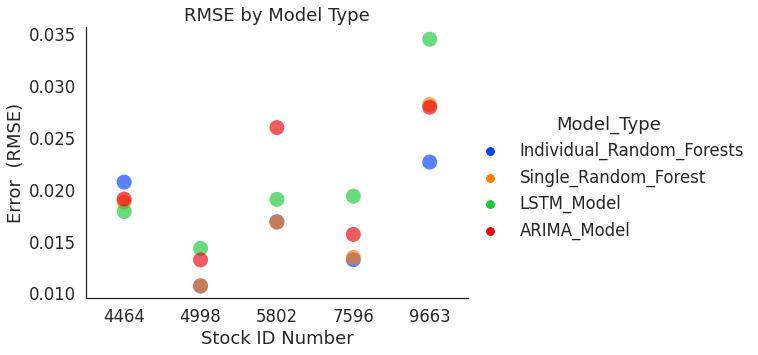

In [221]:
# Plot RMSE by Model Type
sns.set_theme(style="white", palette='bright', font_scale=1.5)

sns.catplot(x='Securities_Code', 
            y='RMSE', 
            data=combined, 
            alpha=0.65, 
            hue='Model_Type', 
            jitter=False, 
            s = 15,
            aspect=12/8).set(title='RMSE by Model Type', 
                        xlabel="Stock ID Number",
                        ylabel= "Error  (RMSE)"
                        )

plt.show()

# Score by Model Type
* Neural Network is not included because even with Google Cloud, I did not have computational capacity to score the model type.
    * However, the existing LSTM model predicted the Sharpe Ratio very close to the mean and would likely have scored poorly, like the ARIMA model, which also made predictions close to the mean.

In [249]:
scores = [3.05, .406, -1.43]
models = ['Individual \nRandom \nForests', 'Single \nRandom Forest', 'ARIMA']

score_dict = {'Scores':scores,'Models':models}

score_df = pd.DataFrame(score_dict)

score_df

,Scores,Models
0,3.050,Individual \nRandom \nForests
1,0.406,Single \nRandom Forest
2,-1.430,ARIMA


## Plot Score

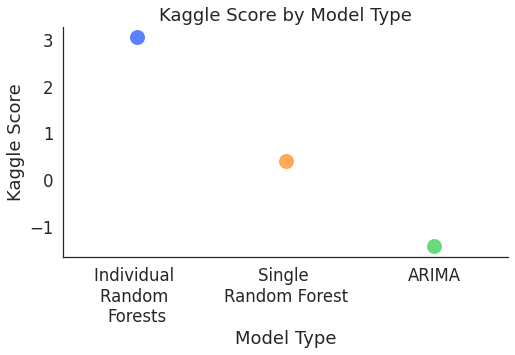

In [250]:
# Plot RMSE by Model Type
sns.set_theme(style="white", palette='bright', font_scale=1.5)

sns.catplot(x='Models', 
            y='Scores', 
            data=score_df, 
            alpha=0.65, 
            jitter=False, 
            s = 15,
            aspect=12/8).set(title='Kaggle Score by Model Type', 
                        xlabel="Model Type",
                        ylabel= "Kaggle Score"
                        )
#plt.xticks(rotation=45, ha="right")
plt.show()

# Conclusion